# BusSim experiments
    authors: Minh Kieu
    created: 7 July 2019
    version: 0.1 (jupyter)

#### Description: 

This code will apply Particle Filter on BusSim, requires:
1. model BusSim_static_v2.py and BusSim_static_deterministic.py
2. Calibration files in folder Calibration (note: Run BusSim_model_calibration_v3.py if you need these files)
3. Data files in Data folder (note: Run BusSim_dynamic.py to generate these Synthetic Data)


#### Import Model

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
#from BusSim_static_v2 import Bus,BusStop,Model
from ParticleFilter_MK import ParticleFilter
from copy import deepcopy
import pandas as pd

#### Step 1: Load calibration results

Run BusSim_model_calibration_v3_deterministic if you want to calibrate a deterministic BusSim model

Run BusSim_model_calibration_v3_static to calibrate a stochastic BusSim model

The BusSim_model_dynamic was used for generating the data

These models can be calibrated using BusSim_model_calibration_v3.py


In [4]:
def load_calibrated_params_IncreaseRate(IncreaseRate):
    #name0 = ['/Users/minhlkieu/Dropbox/Minh_UoL/DA/ABM/BusSim/Calibration/BusSim_Model2_calibration_IncreaseRate_',str(IncreaseRate),'.pkl']
    name0 = ['./Calibration/BusSim_Model2_calibration_IncreaseRate_',str(IncreaseRate),'.pkl']
    str1 = ''.join(name0)    
    with open(str1, 'rb') as f:      
        model_params, best_mean_model2,Sol_archived_mean,Sol_archived_std,PI_archived = pickle.load(f)

    #name0 = ['/Users/minhlkieu/Dropbox/Minh_UoL/DA/ABM/BusSim/Calibration/BusSim_Model1_calibration_IncreaseRate_',str(IncreaseRate),'.pkl']
    name0 = ['./Calibration/BusSim_Model1_calibration_IncreaseRate_',str(IncreaseRate),'.pkl']
    str1 = ''.join(name0)    
    with open(str1, 'rb') as f:      
        model_params, best_mean_model1,Sol_archived_mean,Sol_archived_std,PI_archived = pickle.load(f)
    return best_mean_model1,best_mean_model2    

def load_calibrated_params_maxDemand(maxDemand):
    name0 = ['./Calibration/BusSim_Model2_calibration_static_maxDemand_',str(maxDemand),'.pkl']
    str1 = ''.join(name0)    
    with open(str1, 'rb') as f:      
        model_params, best_mean_model2,Sol_archived_mean,Sol_archived_std,PI_archived = pickle.load(f)

    name0 = ['./Calibration/BusSim_Model1_calibration_static_maxDemand_',str(maxDemand),'.pkl']
    str1 = ''.join(name0)    
    with open(str1, 'rb') as f:      
        model_params, best_mean_model1,Sol_archived_mean,Sol_archived_std,PI_archived = pickle.load(f)
    return best_mean_model1,best_mean_model2    

def load_actual_params_IncreaseRate(IncreaseRate):
    #load up a model from a Pickle    
    #with open('C:/Users/geomlk/Dropbox/Minh_UoL/DA/ABM/BusSim/Data/Realtime_data_IncreaseRate_9.pkl','rb') as f2:

    name0 = ['./Data/Realtime_data_IncreaseRate_',str(IncreaseRate),'.pkl']
    str1 = ''.join(name0)    

    with open(str1, 'rb') as f:
        model_params,t,x,GroundTruth = pickle.load(f)
    return model_params,t,x,GroundTruth

def load_actual_params_maxDemand(maxDemand):
    #load up a model from a Pickle    
    #with open('C:/Users/geomlk/Dropbox/Minh_UoL/DA/ABM/BusSim/Data/Realtime_data_IncreaseRate_9.pkl','rb') as f2:

    name0 = ['./Data/Realtime_data_static_maxDemand_',str(maxDemand),'.pkl']
    str1 = ''.join(name0)    

    with open(str1, 'rb') as f:
        model_params,t,x,GroundTruth = pickle.load(f)
    return model_params,t,x,GroundTruth

def rmse(yhat,y):
    return np.sqrt(np.square(np.subtract(yhat, y).mean()))

def mae(yhat,y):
    return np.mean(np.abs(yhat-y))

#### Step 2: Define function to apply PF to calibrated BusSim

In [5]:
def apply_PF_IncreaseRate(IncreaseRate,model0,GroundTruth0):
    filter_params = {
        'number_of_particles': 500,
        'arr_std': 0.0005,
        'dep_std':0.0005,
        'traffic_std':0.0005,
        'resample_window': 1,
        'do_copies': True,
        'do_save': True
        }
    model = deepcopy(model0)
    pf = ParticleFilter(model, **filter_params)

    for niter in range(len(GroundTruth0)):
        model.step()
        true_state = GroundTruth0[niter]
        measured_state = true_state #+ np.random.normal(0, 0., true_state.shape)  #to add noise in the measured_state if needed
        pf.step(measured_state, true_state)
    x = np.array([bus.trajectory for bus in pf.models[np.argmax(pf.weights)].buses]).T    
    return x

def apply_PF_maxDemand(maxDemand,model0,GroundTruth0):
    filter_params = {
        'number_of_particles': 500,
        'arr_std': 0.0005,
        'dep_std':0.0005,
        'traffic_std':0.0005,
        'resample_window': 1,
        'do_copies': True,
        'do_save': True
        }
    model = deepcopy(model0)
    pf = ParticleFilter(model, **filter_params)

    for niter in range(len(GroundTruth0)):
        model.step()
        true_state = GroundTruth0[niter]
        measured_state = true_state #+ np.random.normal(0, 0., true_state.shape)  #to add noise in the measured_state if needed
        pf.step(measured_state, true_state)
    x = np.array([bus.trajectory for bus in pf.models[np.argmax(pf.weights)].buses]).T    
    return x

#### Step 3: Define functions to do analysis of IncreaseRate and MaxDemand

In [7]:
def IncreaseRate_analysis():
    Results = [0,0]
    do_plot=True
    for IncreaseRate in range(1,20,2):
        print('IncreaseRate = ',IncreaseRate)
        '''load the synthetic realtime data and calibrated params'''
        model_params, t,x,GroundTruth0 = load_actual_params_IncreaseRate(IncreaseRate)
        best_mean_model1,best_mean_model2 = load_calibrated_params_IncreaseRate(IncreaseRate)
        '''load BusSim-stochastic model'''
        from BusSim_static_v2 import Model as Model2
        ArrivalRate = best_mean_model2[0:(model_params['NumberOfStop'])]
        DepartureRate = best_mean_model2[model_params['NumberOfStop']:(2*model_params['NumberOfStop'])]    
        TrafficSpeed = best_mean_model2[-2]
        #load model
        model2 = Model2(model_params, TrafficSpeed,ArrivalRate,DepartureRate)
        t = np.arange(0, model_params['EndTime'], model_params['dt'])

        x2=apply_PF_IncreaseRate(IncreaseRate,model2,GroundTruth0)    
        
        from BusSim_static_deterministic import Model as Model1
        ArrivalRate = best_mean_model1[0:(model_params['NumberOfStop'])]
        DepartureRate = best_mean_model1[model_params['NumberOfStop']:(2*model_params['NumberOfStop'])]    
        TrafficSpeed = best_mean_model1[-2]
        #load model
        model1 = Model1(model_params, TrafficSpeed,ArrivalRate,DepartureRate)

        x1=apply_PF_IncreaseRate(IncreaseRate,model1,GroundTruth0)    

        x1[x1 <= 0] = np.nan
        x1[x1 >= model_params['NumberOfStop']*model_params['LengthBetweenStop']-1] = np.nan
        x2[x2 <= 0] = np.nan
        x2[x2 >= model_params['NumberOfStop']*model_params['LengthBetweenStop']-1] = np.nan


        if do_plot:
            plt.figure(3, figsize=(16 / 2, 9 / 2))
            plt.clf()            
            plt.plot(t, x, linewidth=1,color='black',linestyle = '-')
            plt.plot(t, x2, linewidth=1.5,linestyle = ':',color='r')
            plt.ylabel('Distance (m)')
            plt.xlabel('Time (s)')
            plt.plot(t, x1, linewidth=1.5,linestyle = '--',color='b')

            plt.plot([], [], linewidth=1.5,linestyle = ':',color='r',label='BusSim-stochastic')
            plt.plot([], [], linewidth=1.5,linestyle = '--',color='b',label='BusSim-deterministic')
            plt.plot([], [], linewidth=1,color='black',linestyle = '-',label='Real-time')
    
            plt.legend()
            plt.show()
            name0 = ['./Figures/Fig_PF_IncreaseRate_',str(IncreaseRate),'.pdf']
            str1 = ''.join(name0)    
            plt.savefig(str1, dpi=200,bbox_inches='tight')
        
        x1[np.isnan(x1)]=0
        x2[np.isnan(x2)]=0
        x[np.isnan(x)]=0
        RMSE1 = rmse(x1,x)
        RMSE2 = rmse(x2,x)
        Results =  np.vstack((Results,[RMSE1,RMSE2]))
        
    do_plot_results=True
    if do_plot_results:
        plt.figure(3, figsize=(16 / 2, 9 / 2))
        plt.clf()            
        plt.plot(np.arange(1,20,2),Results[1:,0],linewidth=1.5,linestyle = '--',color='b',label='BusSim-deterministic')
        plt.plot(np.arange(1,20,2),Results[1:,1],linewidth=1.5,linestyle = ':',color='r',label='BusSim-stochastic')
        plt.ylabel('RMSE (m)')
        plt.xlabel(r'$\xi$ (%)')
 
        plt.legend()
        plt.show()
        plt.savefig('./Figures/Fig_PF_results_IncreaseRate.pdf', dpi=200,bbox_inches='tight')

    return Results

def maxDemand_analysis():
    Results = [0,0]
    do_plot=False
    for maxDemand in range(1,10,2):
        maxDemand=maxDemand/2
        print('maxDemand = ',maxDemand)
        '''load the synthetic realtime data and calibrated params'''
        model_params, t,x,GroundTruth0 = load_actual_params_maxDemand(maxDemand)
        best_mean_model1,best_mean_model2 = load_calibrated_params_maxDemand(maxDemand)
        '''load BusSim-stochastic model'''
        from BusSim_static_v2 import Model as Model2
        ArrivalRate = best_mean_model2[0:(model_params['NumberOfStop'])]
        DepartureRate = best_mean_model2[model_params['NumberOfStop']:(2*model_params['NumberOfStop'])]    
        TrafficSpeed = best_mean_model2[-1]
        #load model
        model2 = Model2(model_params, TrafficSpeed,ArrivalRate,DepartureRate)
        t = np.arange(0, model_params['EndTime'], model_params['dt'])

        x2=apply_PF_maxDemand(maxDemand,model2,GroundTruth0)    
        
        from BusSim_static_deterministic import Model as Model1
        ArrivalRate = best_mean_model1[0:(model_params['NumberOfStop'])]
        DepartureRate = best_mean_model1[model_params['NumberOfStop']:(2*model_params['NumberOfStop'])]    
        TrafficSpeed = best_mean_model1[-1]
        #load model
        model1 = Model1(model_params, TrafficSpeed,ArrivalRate,DepartureRate)

        x1=apply_PF_maxDemand(maxDemand,model1,GroundTruth0)    

        if do_plot:
            plt.figure(3, figsize=(16 / 2, 9 / 2))
            plt.clf()            
            plt.plot(t, x2, linewidth=1,linestyle = ':',color='r',label='BusSim-stochastic')
            plt.plot(t, x, linewidth=1,color='black',linestyle = '-',label='Real-time')
            plt.ylabel('Distance (m)')
            plt.xlabel('Time (s)')
            plt.plot(t, x1, linewidth=.5,linestyle = '--',color='b',label='BusSim-deterministic')
            plt.legend()
            plt.show()
            name0 = ['./Figures/Fig_PF_maxDemand_',str(maxDemand),'.pdf']
            str1 = ''.join(name0)    
            plt.savefig(str1, dpi=200,bbox_inches='tight')
        
        x1[x1 <= 0] = 0
        x1[x1 >= model_params['NumberOfStop']*model_params['LengthBetweenStop']-1] = 0
        x2[x2 <= 0] = 0
        x2[x2 >= model_params['NumberOfStop']*model_params['LengthBetweenStop']-1] = 0
        x1[np.isnan(x1)]=0
        x2[np.isnan(x2)]=0
        x[np.isnan(x)]=0
        RMSE1 = rmse(x1,x)
        RMSE2 = rmse(x2,x)
        Results =  np.vstack((Results,[RMSE1,RMSE2]))
        

    do_plot_results=True
    if do_plot_results:
        plt.figure(3, figsize=(16 / 2, 9 / 2))
        plt.clf()            
        plt.plot(np.arange(1,11,2),Results[1:,0],linewidth=1.5,linestyle = '--',color='b',label='BusSim-deterministic')
        plt.plot(np.arange(1,11,2),Results[1:,1],linewidth=1.5,linestyle = ':',color='r',label='BusSim-stochastic')
        plt.ylabel('RMSE (m)')
        plt.xlabel(r'$maxDemand$ (passenger/min)')
        plt.xticks(np.arange(1,11,2), (np.arange(1,11,2)/2))
 
        plt.legend()
        plt.show()
        plt.savefig('./Figures/Fig_PF_results_maxDemand.pdf', dpi=200,bbox_inches='tight')


    return Results

def IncreaseRate_analysis_NO_CALIBRATION():
    Results = [0,0]
    do_plot=True
    for IncreaseRate in range(1,20,2):
        print('IncreaseRate = ',IncreaseRate)
        '''load the synthetic realtime data and calibrated params'''
        model_params, t,x,GroundTruth0 = load_actual_params_IncreaseRate(IncreaseRate)

        NumberOfStop=20
        minDemand=0.5
        maxDemand=2
        
        #Initialise the ArrivalRate and DepartureRate
        ArrivalRate = np.random.uniform(minDemand / 60, maxDemand / 60, NumberOfStop)
        DepartureRate = np.sort(np.random.uniform(0.05, 0.5,NumberOfStop))
        #DepartureRate = np.linspace(0.05, 0.5,NumberOfStop)
        DepartureRate[0]=0
        TrafficSpeed = np.random.uniform(11, 17)   
        #Initialise the model parameters
        model_params = {
            "dt": 10,
            "minDemand":minDemand,        
            "NumberOfStop": NumberOfStop,
            "LengthBetweenStop": 2000,
            "EndTime": 6000,
            "Headway": 5 * 60,
            "BurnIn": 1 * 60,
            "AlightTime": 1,
            "BoardTime": 3,
            "StoppingTime": 3,
            "BusAcceleration": 3  # m/s          
        }

        '''load BusSim-stochastic model'''
        from BusSim_static_v2 import Model as Model2
        #load model
        model2 = Model2(model_params, TrafficSpeed,ArrivalRate,DepartureRate)
        t = np.arange(0, model_params['EndTime'], model_params['dt'])

        x2=apply_PF_IncreaseRate(IncreaseRate,model2,GroundTruth0)    
        
        from BusSim_static_deterministic import Model as Model1
        ArrivalRate = np.random.uniform(minDemand / 60, maxDemand / 60, NumberOfStop)
        DepartureRate = np.sort(np.random.uniform(0.05, 0.5,NumberOfStop))
        #DepartureRate = np.linspace(0.05, 0.5,NumberOfStop)
        DepartureRate[0]=0
        TrafficSpeed = np.random.uniform(11, 17)   
         #load model
        model1 = Model1(model_params, TrafficSpeed,ArrivalRate,DepartureRate)

        x1=apply_PF_IncreaseRate(IncreaseRate,model1,GroundTruth0)    

        x1[x1 <= 0] = np.nan
        x1[x1 >= model_params['NumberOfStop']*model_params['LengthBetweenStop']-1] = np.nan
        x2[x2 <= 0] = np.nan
        x2[x2 >= model_params['NumberOfStop']*model_params['LengthBetweenStop']-1] = np.nan


        if do_plot:
            plt.figure(3, figsize=(16 / 2, 9 / 2))
            plt.clf()            
            plt.plot(t, x, linewidth=1,color='black',linestyle = '-')
            plt.plot(t, x2, linewidth=1.5,linestyle = ':',color='r')
            plt.ylabel('Distance (m)')
            plt.xlabel('Time (s)')
            plt.plot(t, x1, linewidth=1.5,linestyle = '--',color='b')

            plt.plot([], [], linewidth=1.5,linestyle = ':',color='r',label='BusSim-stochastic')
            plt.plot([], [], linewidth=1.5,linestyle = '--',color='b',label='BusSim-deterministic')
            plt.plot([], [], linewidth=1,color='black',linestyle = '-',label='Real-time')
    
            plt.legend()
            plt.show()
            name0 = ['./Figures/Fig_PF_IncreaseRate_',str(IncreaseRate),'_NO_CALIBRATION.pdf']
            str1 = ''.join(name0)    
            plt.savefig(str1, dpi=200,bbox_inches='tight')
        
        x1[np.isnan(x1)]=0
        x2[np.isnan(x2)]=0
        x[np.isnan(x)]=0
        RMSE1 = rmse(x1,x)
        RMSE2 = rmse(x2,x)
        Results =  np.vstack((Results,[RMSE1,RMSE2]))
        
    do_plot_results=True
    if do_plot_results:
        plt.figure(3, figsize=(16 / 2, 9 / 2))
        plt.clf()            
        plt.plot(np.arange(1,20,2),Results[1:,0],linewidth=1.5,linestyle = '--',color='b',label='BusSim-deterministic')
        plt.plot(np.arange(1,20,2),Results[1:,1],linewidth=1.5,linestyle = ':',color='r',label='BusSim-stochastic')
        plt.ylabel('RMSE (m)')
        plt.xlabel(r'$\xi$ (%)')
 
        plt.legend()
        plt.show()
        plt.savefig('./Figures/Fig_PF_results_IncreaseRate_NO_CALIBRATION.pdf', dpi=200,bbox_inches='tight')

    return Results

def maxDemand_analysis_NO_CALIBRATION():
    Results = [0,0]
    do_plot=False
    for maxDemand in range(1,10,2):
        maxDemand=maxDemand/2
        print('maxDemand = ',maxDemand)
        '''load the synthetic realtime data and calibrated params'''
        model_params, t,x,GroundTruth0 = load_actual_params_maxDemand(maxDemand)
        NumberOfStop=20
        minDemand=0.5
        maxDemand=2
        
        #Initialise the ArrivalRate and DepartureRate
        ArrivalRate = np.random.uniform(minDemand / 60, maxDemand / 60, NumberOfStop)
        DepartureRate = np.sort(np.random.uniform(0.05, 0.5,NumberOfStop))
        #DepartureRate = np.linspace(0.05, 0.5,NumberOfStop)
        DepartureRate[0]=0
        TrafficSpeed = np.random.uniform(11, 17)   
        #Initialise the model parameters
        model_params = {
            "dt": 10,
            "minDemand":minDemand,        
            "NumberOfStop": NumberOfStop,
            "LengthBetweenStop": 2000,
            "EndTime": 6000,
            "Headway": 5 * 60,
            "BurnIn": 1 * 60,
            "AlightTime": 1,
            "BoardTime": 3,
            "StoppingTime": 3,
            "BusAcceleration": 3  # m/s          
        }

        '''load BusSim-stochastic model'''
        from BusSim_static_v2 import Model as Model2
        #load model
        model2 = Model2(model_params, TrafficSpeed,ArrivalRate,DepartureRate)
        t = np.arange(0, model_params['EndTime'], model_params['dt'])

        x2=apply_PF_maxDemand(maxDemand,model2,GroundTruth0)    
        
        from BusSim_static_deterministic import Model as Model1
        ArrivalRate = np.random.uniform(minDemand / 60, maxDemand / 60, NumberOfStop)
        DepartureRate = np.sort(np.random.uniform(0.05, 0.5,NumberOfStop))
        #DepartureRate = np.linspace(0.05, 0.5,NumberOfStop)
        DepartureRate[0]=0
        TrafficSpeed = np.random.uniform(11, 17)   
         #load model
        model1 = Model1(model_params, TrafficSpeed,ArrivalRate,DepartureRate)

        x1=apply_PF_maxDemand(maxDemand,model1,GroundTruth0)    

        x1[x1 <= 0] = np.nan
        x1[x1 >= model_params['NumberOfStop']*model_params['LengthBetweenStop']-1] = np.nan
        x2[x2 <= 0] = np.nan
        x2[x2 >= model_params['NumberOfStop']*model_params['LengthBetweenStop']-1] = np.nan


        if do_plot:
            plt.figure(3, figsize=(16 / 2, 9 / 2))
            plt.clf()            
            plt.plot(t, x, linewidth=1,color='black',linestyle = '-')
            plt.plot(t, x2, linewidth=1.5,linestyle = ':',color='r')
            plt.ylabel('Distance (m)')
            plt.xlabel('Time (s)')
            plt.plot(t, x1, linewidth=1.5,linestyle = '--',color='b')

            plt.plot([], [], linewidth=1.5,linestyle = ':',color='r',label='BusSim-stochastic')
            plt.plot([], [], linewidth=1.5,linestyle = '--',color='b',label='BusSim-deterministic')
            plt.plot([], [], linewidth=1,color='black',linestyle = '-',label='Real-time')
    
            plt.legend()
            plt.show()
            name0 = ['./Figures/Fig_PF_maxDemand_',str(maxDemand),'_NO_CALIBRATION.pdf']
            str1 = ''.join(name0)    
            plt.savefig(str1, dpi=200,bbox_inches='tight')
        
        x1[np.isnan(x1)]=0
        x2[np.isnan(x2)]=0
        x[np.isnan(x)]=0
        RMSE1 = rmse(x1,x)
        RMSE2 = rmse(x2,x)
        Results =  np.vstack((Results,[RMSE1,RMSE2]))
        
    do_plot_results=True
    if do_plot_results:
        plt.figure(3, figsize=(16 / 2, 9 / 2))
        plt.clf()            
        plt.plot(np.arange(1,11,2),Results[1:,0],linewidth=1.5,linestyle = '--',color='b',label='BusSim-deterministic')
        plt.plot(np.arange(1,11,2),Results[1:,1],linewidth=1.5,linestyle = ':',color='r',label='BusSim-stochastic')
        plt.ylabel('RMSE (m)')
        plt.xlabel(r'$maxDemand$ (passenger/min)')
        plt.xticks(np.arange(1,11,2), (np.arange(1,11,2)/2))
 
        plt.legend()
        plt.show()
        plt.savefig('./Figures/Fig_PF_results_maxDemand_NO_CALIBRATION.pdf', dpi=200,bbox_inches='tight')

    return Results

#### Step 4: Finally, we can now actually do some analysis


IncreaseRate =  1


/Users/geomik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater_equal
/Users/geomik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal


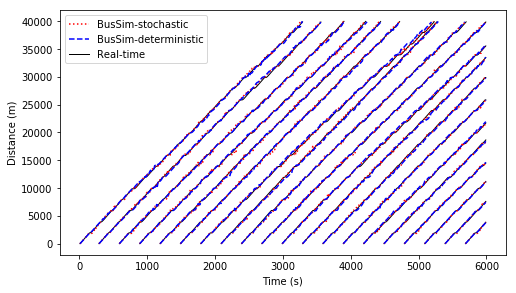

IncreaseRate =  3


<Figure size 432x288 with 0 Axes>

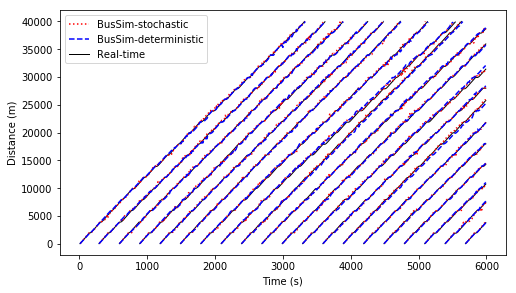

IncreaseRate =  5


<Figure size 432x288 with 0 Axes>

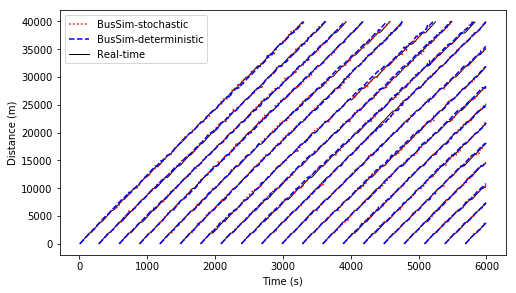

IncreaseRate =  7


<Figure size 432x288 with 0 Axes>

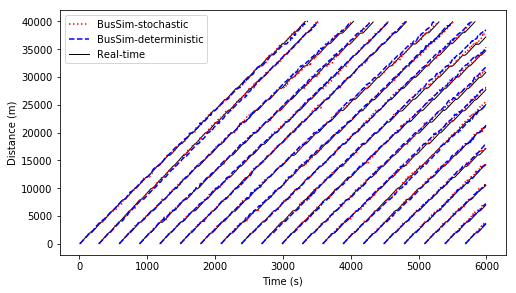

IncreaseRate =  9


<Figure size 432x288 with 0 Axes>

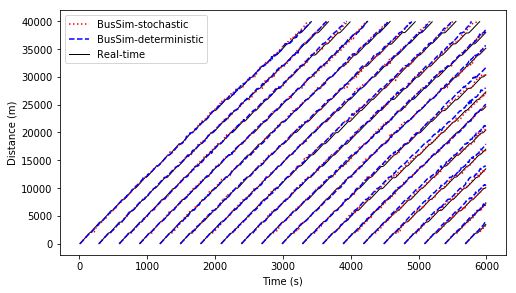

IncreaseRate =  11


<Figure size 432x288 with 0 Axes>

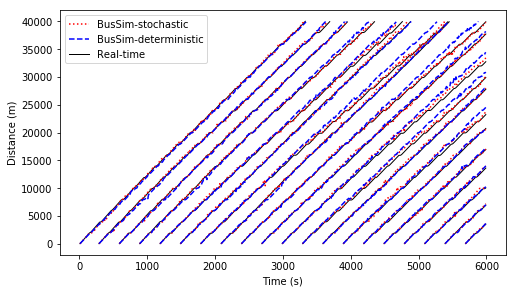

IncreaseRate =  13


<Figure size 432x288 with 0 Axes>

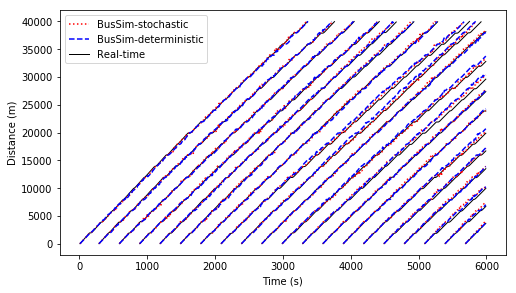

IncreaseRate =  15


<Figure size 432x288 with 0 Axes>

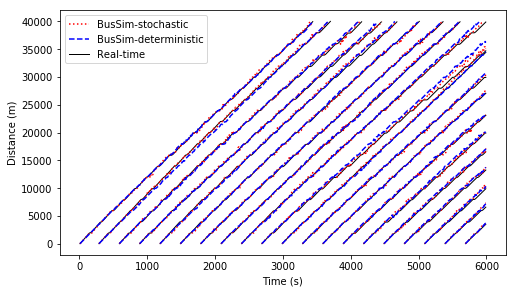

IncreaseRate =  17


<Figure size 432x288 with 0 Axes>

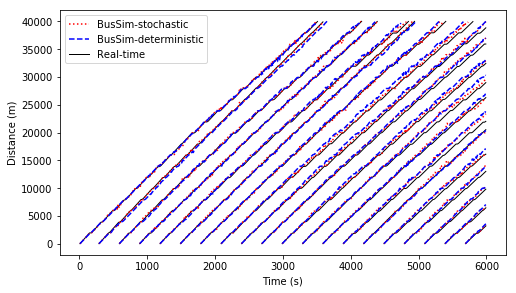

IncreaseRate =  19


<Figure size 432x288 with 0 Axes>

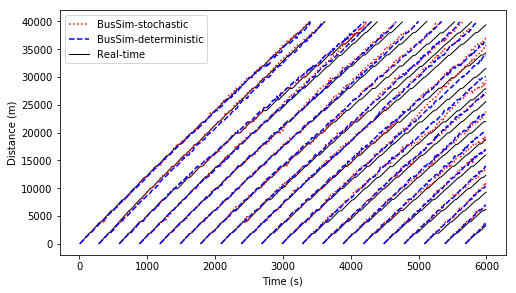

<Figure size 432x288 with 0 Axes>

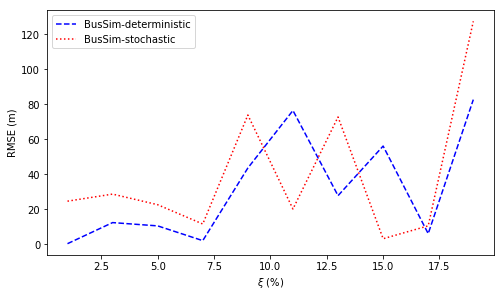

<Figure size 432x288 with 0 Axes>

In [8]:
Results=IncreaseRate_analysis()
    #Results=maxDemand_analysis()
    
    #Results = IncreaseRate_analysis_NO_CALIBRATION()
    #Results = maxDemand_analysis_NO_CALIBRATION()